Epoch 1000/16500, Loss: 1.609314203776755
Epoch 2000/16500, Loss: 1.6086779816907322
Epoch 3000/16500, Loss: 1.6049965730684477
Epoch 4000/16500, Loss: 1.5860100210813926
Epoch 5000/16500, Loss: 1.5262487454182203
Epoch 6000/16500, Loss: 1.4577760491161347
Epoch 7000/16500, Loss: 1.4233727221650172
Epoch 8000/16500, Loss: 1.4086909143008974
Epoch 9000/16500, Loss: 1.401652291252536
Epoch 10000/16500, Loss: 1.397804923458962
Epoch 11000/16500, Loss: 1.3954763875046652
Epoch 12000/16500, Loss: 1.3939560079883286
Epoch 13000/16500, Loss: 1.3929048257243413
Epoch 14000/16500, Loss: 1.3921452077215313
Epoch 15000/16500, Loss: 1.3915767759236501
Epoch 16000/16500, Loss: 1.391139253141164


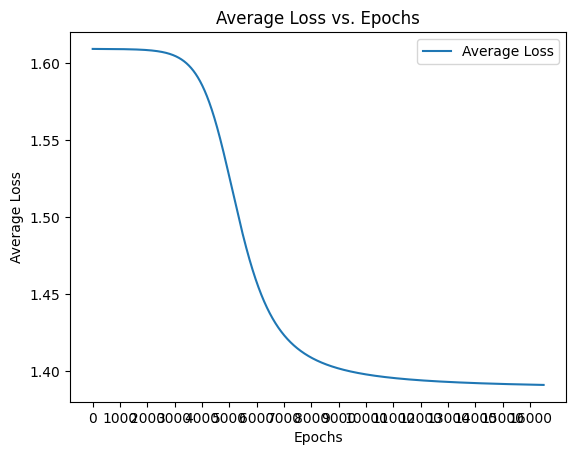

Predictions for 'read': [('report', 0.24955581009086752), ('journal', 0.24931577261796853), ('article', 0.24907619201974388)]


In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt

class CBOW:
    def __init__(self, vocab_size, word_index, reverse_word_index, embedding_dim, hidden_dim, learning_rate=0.001):
        np.random.seed(42)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.word_index = word_index
        self.reverse_word_index = reverse_word_index
        # Initialize weights randomly
        self.W1 = np.random.randn(vocab_size, hidden_dim) * 0.01
        self.W2 = np.random.randn(hidden_dim, vocab_size) * 0.01

    def generate_one_hot(self, word_idx):
        one_hot = np.zeros(self.vocab_size)
        one_hot[int(word_idx)] = 1
        return one_hot

    def linear_activation(self, x):
        return x

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0)

    def forward_pass(self, context):
        hidden_input = np.dot(self.W1.T, context)
        h = self.linear_activation(hidden_input)
        u = np.dot(self.W2.T, h)
        output_probs = self.softmax(u)
        return h, output_probs

    def backward_pass(self, context, target, h, output_probs):
        error_output = output_probs - target
        dW2 = np.outer(error_output, h)
        error_hidden = np.dot(self.W2, error_output)
        dW1 = np.outer(error_hidden, context)
        return dW1.T, dW2.T

    def update_weights(self, dW1, dW2):
        self.W1 -= self.learning_rate * dW1
        self.W2 -= self.learning_rate * dW2

    def train(self, corpus, epochs=1):
        losses = []
        for epoch in range(epochs):
            total_loss = 0.0
            for sentence in corpus:
                context_words = sentence.split()[:-1]
                target_word = sentence.split()[-1]

                context_vectors = [self.generate_one_hot(self.reverse_word_index[word]) for word in context_words]
                context = np.mean(context_vectors, axis=0)
                target = self.generate_one_hot(self.reverse_word_index[target_word])
                h, output_probs = self.forward_pass(context)
                j_star = int(target.argmax())

                # Calculate cross-entropy loss
                loss = -np.log(output_probs[j_star])  # E = - ln(y)
                total_loss += loss

                dW1, dW2 = self.backward_pass(context, target, h, output_probs)
                self.update_weights(dW1, dW2)

            average_loss = total_loss / len(corpus)
            losses.append(average_loss)

            # Optional: Print loss for every 1000 epochs
            if (epoch + 1) % 1000 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss}")

        plt.plot(range(1, epochs + 1), losses, label='Average Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Average Loss')
        plt.title('Average Loss vs. Epochs')
        plt.xticks(range(0, epochs + 1, 1000))  # Set x-axis ticks to be divisible by 1000
        plt.legend()
        plt.show()

    def predict(self, input_word, top_n=3):
        if input_word in self.reverse_word_index:
            input_vector = self.generate_one_hot(self.reverse_word_index[input_word])
            _, output_probs = self.forward_pass(input_vector)
            top_indices = np.argsort(output_probs)[-top_n:][::-1]
            predicted_words = [(self.word_index[str(i)], output_probs[i]) for i in top_indices]
            return predicted_words
        else:
            return "Word not in vocabulary", None

# Sample corpus with different words
corpus = [
    "read book",
    "read article",
    "read journal",
    "read report",
]

epochs = 16500
text_corpus = ' '.join(corpus)

# Tokenize the text into words
words = text_corpus.split()

# Count the occurrences of each word
word_counts = Counter(words)

# Sort words by their counts in descending order
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)

# Create a dictionary with unique words and assign an index
word_index = {'0': sorted_words[0]}  # Assign '0' to the most repeated word
word_index.update({str(i + 1): word for i, word in enumerate(sorted_words[1:])})
reverse_word_index = {value: key for key, value in word_index.items()}

vocab_size = len(word_counts)
embedding_dim = vocab_size
hidden_dim = 3

# Initialize CBOW model
cbow = CBOW(vocab_size, word_index, reverse_word_index, embedding_dim=embedding_dim, hidden_dim=hidden_dim)

# Train the model
cbow.train(corpus, epochs)

# Predict words based on input
predictions = cbow.predict("read")
print("Predictions for 'read':", predictions)
